# Evaluation

Tahap Evaluation bertujuan untuk mengukur performa model
yang telah dibangun pada tahap Modeling.

Evaluasi dilakukan menggunakan data testing
yang tidak digunakan selama proses training,
sehingga performa yang dihasilkan
merepresentasikan kemampuan generalisasi model.


In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import StratifiedKFold, cross_val_score


ModuleNotFoundError: No module named 'google'

## 1. Memuat Model dan Data

Pada tahap evaluasi, digunakan:
- model SVM hasil tahap modeling
- scaler untuk normalisasi fitur
- data hasil preprocessing

Tidak dilakukan pelatihan ulang pada tahap ini.


In [2]:
PREP_DIR = "/content/drive/MyDrive/MATKUL/PSD/UAS/preprocessed_data"

data = np.load(f"{PREP_DIR}/mfcc_features.npz")

X_train_feat = data["X_train"]
X_test_feat  = data["X_test"]
y_train_enc  = data["y_train"]
y_test_enc   = data["y_test"]

with open(f"{PREP_DIR}/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)



In [3]:
MODEL_DIR = "/content/drive/MyDrive/MATKUL/PSD/UAS/model_svm_mfcc"

with open(f"{MODEL_DIR}/svm_mfcc_model.pkl", "rb") as f:
    svm = pickle.load(f)

with open(f"{MODEL_DIR}/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)



## 2. Normalisasi Feature untuk Evaluasi

Fitur MFCC pada data training dan testing
dinormalisasi menggunakan scaler
yang telah dipelajari pada tahap modeling.

Hal ini penting untuk menjaga konsistensi preprocessing
dan mencegah *data leakage*.


In [4]:
X_train_scaled = scaler.transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)


## 3. Evaluasi Performa Model pada Data Testing

Pada tahap ini, model dievaluasi menggunakan data testing
yang tidak digunakan selama proses training.

Evaluasi dilakukan dengan:
- menghitung akurasi model
- menampilkan classification report
  (precision, recall, dan F1-score untuk setiap kelas)

Hasil evaluasi ini digunakan untuk menilai
kemampuan generalisasi model terhadap data baru


In [ ]:
y_pred = svm.predict(X_test_scaled)

test_acc = accuracy_score(y_test_enc, y_pred)
print("Test Accuracy:", test_acc)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Test Accuracy: 0.7666666666666667

Classification Report:
                              precision    recall  f1-score   support

black-bellied_whistling_duck       0.75      0.50      0.60         6
              canadian_goose       0.71      0.83      0.77         6
               greylag_goose       0.75      1.00      0.86         6
           pink-footed_goose       1.00      0.83      0.91         6
  white-faced_whistling_duck       0.67      0.67      0.67         6

                    accuracy                           0.77        30
                   macro avg       0.78      0.77      0.76        30
                weighted avg       0.78      0.77      0.76        30



## 4. Confusion Matrix

Confusion Matrix digunakan untuk melihat
pola kesalahan prediksi antar kelas,
serta memastikan tidak terjadi *class collapse*.


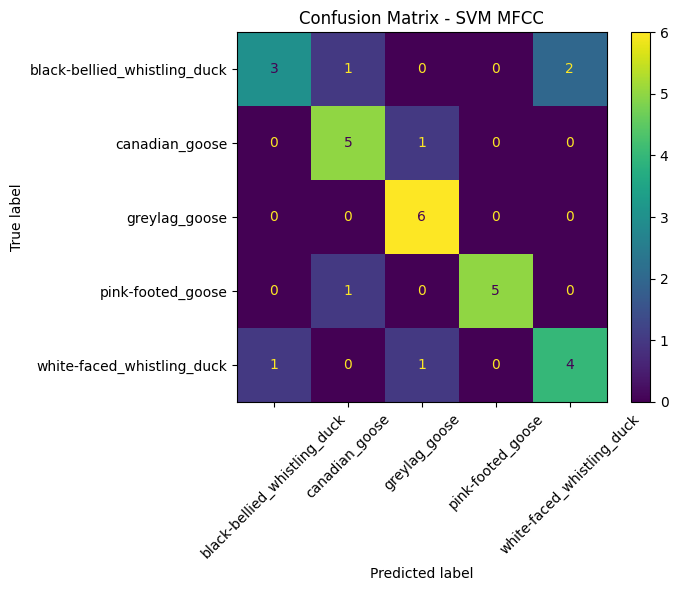

In [6]:
cm = confusion_matrix(y_test_enc, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix - SVM MFCC")
plt.show()


## 5. Perbandingan Akurasi Training dan Testing

Perbandingan akurasi training dan testing
digunakan untuk mengamati potensi overfitting atau underfitting.


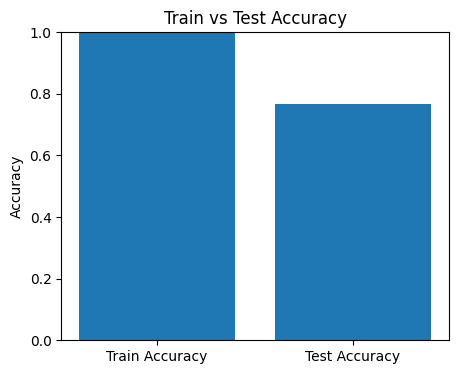

Train Accuracy: 1.0
Test Accuracy : 0.7666666666666667


In [7]:
train_acc = accuracy_score(
    y_train_enc,
    svm.predict(X_train_scaled)
)

plt.figure(figsize=(5,4))
plt.bar(["Train Accuracy", "Test Accuracy"], [train_acc, test_acc])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.show()

print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)


## 6. Cross-Validation Accuracy

Karena SVM tidak memiliki metrik berbasis epoch,
digunakan **cross-validation accuracy**
untuk mengukur stabilitas dan kemampuan generalisasi model.


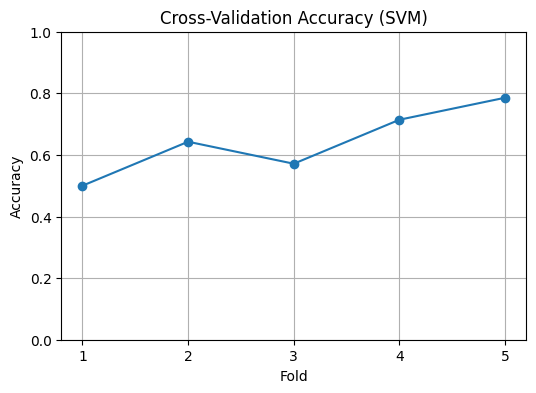

CV scores: [0.5        0.64285714 0.57142857 0.71428571 0.78571429]
Mean CV accuracy: 0.6428571428571428


In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    svm,
    X_train_scaled,
    y_train_enc,
    cv=cv,
    scoring="accuracy"
)

plt.figure(figsize=(6,4))
plt.plot(range(1, 6), cv_scores, marker="o")
plt.ylim(0, 1)
plt.xticks(range(1, 6))
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy (SVM)")
plt.grid(True)
plt.show()

print("CV scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


## 7. Analisis Confidence Prediksi

Selain menghasilkan label prediksi,
model Support Vector Machine (SVM) yang digunakan
juga mampu menghasilkan **nilai probabilitas (confidence)**
untuk setiap kelas.

Confidence menunjukkan tingkat keyakinan model
terhadap hasil prediksi yang diberikan.
Analisis ini penting untuk:
- memahami seberapa yakin model terhadap prediksinya,
- mengidentifikasi prediksi yang ambigu,
- meningkatkan interpretabilitas model,
terutama pada tahap deployment.


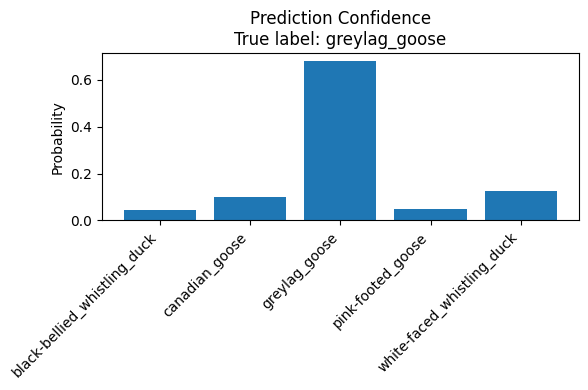

In [14]:
idx = 0

probs = svm.predict_proba(X_test_scaled[idx:idx+1])[0]

plt.figure(figsize=(6,4))
plt.bar(le.classes_, probs)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title(f"Prediction Confidence\nTrue label: {le.classes_[y_test_enc[idx]]}")
plt.tight_layout()
plt.show()


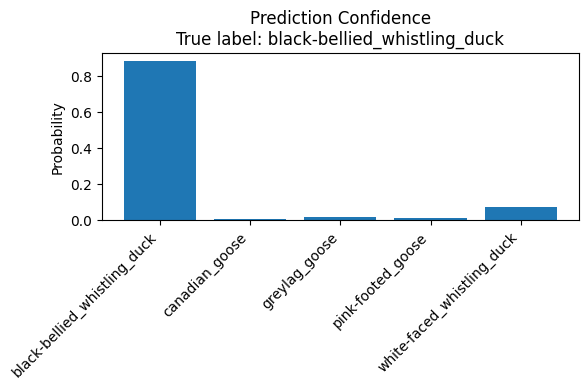

In [16]:
idx = 20
probs = svm.predict_proba(X_test_scaled[idx:idx+1])[0]

plt.figure(figsize=(6,4))
plt.bar(le.classes_, probs)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title(f"Prediction Confidence\nTrue label: {le.classes_[y_test_enc[idx]]}")
plt.tight_layout()
plt.show()


Kesimpulan analisis confidence prediksi:
- Model SVM mampu menghasilkan probabilitas prediksi
  untuk setiap kelas
- Visualisasi confidence membantu interpretasi keputusan model
- Informasi confidence mendukung evaluasi model
  dan meningkatkan kualitas deployment sistem


## 8. Kesimpulan Tahap Evaluasi

Kesimpulan tahap evaluasi adalah sebagai berikut:
1. Model SVM berhasil mengklasifikasikan data testing dengan baik
2. Akurasi testing menunjukkan performa generalisasi yang memadai
3. Confusion matrix menunjukkan distribusi prediksi yang seimbang
4. Cross-validation mengindikasikan model yang stabil

Model siap digunakan pada tahap **Deployment**.
